In [ ]:
from Bio import Phylo 
from io import StringIO

In [ ]:
tree_nwk = "((A,B,C),((D,E,F),G,H),I)"
tree = Phylo.read(StringIO(tree_nwk), format="newick")

In [ ]:
Phylo.draw(tree)

In [ ]:
root = tree.root

In [ ]:
next(iter(root.find_elements(terminal=True)))

In [ ]:
id = 0
def get_new_name():
    global id
    id += 1
    return f"_{id}"

def reset_name():
    global id
    id = 0

In [ ]:
def get_parent(tree, node):
    path = [tree.root] + tree.get_path(node)
    if len(path) <= 1:
        raise ValueError(f"Could not find parent of {node=}, are you sure {node=} is a valid non-root node?")
    parent = path[-2]
    return parent

In [ ]:
reset_name()
for node in tree.find_clades(terminal=False):
    node.name = get_new_name()

In [ ]:
Phylo.draw(tree)

In [ ]:
all_leaf_names = map(lambda x : x.name, tree.find_elements(terminal=True))
print(list(all_leaf_names))

In [ ]:
root.clades[0].clades

In [ ]:
all_clades = tree.find_clades() 
for clade in all_clades:
    if(len(clade.clades) > 2): 
        print(clade)

In [ ]:
polytomies = list(filter(
    lambda x : 
        len(x.clades) > 2 if x != tree.root
        else len(x.clades) > 3
    ,
    tree.find_clades(),
))

In [ ]:
poly_label_map = { polytomy.name: {} for polytomy in polytomies }

In [ ]:
poly_label_map

In [ ]:
for poly in polytomies:
    parent = get_parent(tree, poly)
    print(f"{poly=} {parent=}") 

    for child in poly.clades: 
        leaves = list(child.find_elements(terminal=True))
        # print(f"{child=}, {leaves=}")
        for leaf in leaves: 
            poly_label_map[poly.name][leaf.name] = child.name
    if parent is not None:
        leaves = [ # the rest of the leaves
            l for l in tree.find_elements(terminal=True)
            if l not in poly.find_elements()
        ]
        for leaf in leaves: 
            poly_label_map[poly.name][leaf.name] = parent.name
    print(len(poly_label_map[poly.name]))




In [ ]:
from collections import Counter
polytomy_quartets = { polytomy.name: Counter() for polytomy in polytomies }

In [ ]:
def update_quartet(
    q: tuple[str, str, str, str],
    w: int,
    polytomy_quartets: dict[str, Counter],
):
    # q has format (a, b, c, d), represents ab|cd
    # please check that a,b,c,d are in the leafset 
    # w is an integer weight
    for poly in polytomies: 
        pn = poly.name 
        relabelled_tuple = tuple(map(
            lambda u: poly_label_map[pn][u],
            q
        ))
        if len(set(relabelled_tuple)) == 4: # four different children
            print(f"Updating {pn=}: {relabelled_tuple=}")
            polytomy_quartets[pn][relabelled_tuple] += w
            return # a quartet can be in at most one polytomy

In [ ]:
update_quartet(
    ('A', 'B', 'C', 'D'),
    w = 1,
    polytomy_quartets=polytomy_quartets,
)

In [ ]:
import os 
from pathlib import Path

output_path = "/projects/illinois/eng/cs/warnow/zxliu2/QuartetPolytomy/tmp"
run_name = "test_qp"

FOLDER = Path(output_path) / run_name

In [ ]:
for polytomy in polytomies:
    print(polytomy.name)
    polytomy_folder = FOLDER / polytomy.name
    os.makedirs(polytomy_folder, exist_ok=True)
    # what happens if the leafset is not fully determined? for neighbours a,b,c,d add 
    # ab|cd, ac|bd, and ad|bc so that no bias
    # and make sure each leaf is in at least one quartet.
    with open(polytomy_folder / 'quartets.nwk', 'w') as qf:
        poly_neighbours = list(set(poly_label_map[polytomy.name].values())) # 
        for i in range(len(poly_neighbours) - 3):
            a, b, c, d = poly_neighbours[i:i+4]
            qf.write(f'(({a},{b}),({c},{d}));\n')
            qf.write(f'(({a},{c}),({b},{d}));\n')
            qf.write(f'(({a},{d}),({c},{d}));\n')

        for (a, b, c, d), w in polytomy_quartets[polytomy.name].items():
            qf.write(f'(({a},{b}),({c},{d}));\n' * w)
    

# Stitching

In [140]:
tree_pt = Phylo.read(
    StringIO("""((
             (
                (A,B,C,D)_2,
                (E,F,G,H)_3,
                (I,J)_4
            )_5,K)_1
    )_0"""), format="newick"
)
pt_name = "_5"
resolution1 = Phylo.read(
    StringIO("((_1,_2),(_3,_4))"), format="newick"
)
resolution2 = Phylo.read(
    StringIO("((E,F),(G,(H,_5)))"), format="newick"
)

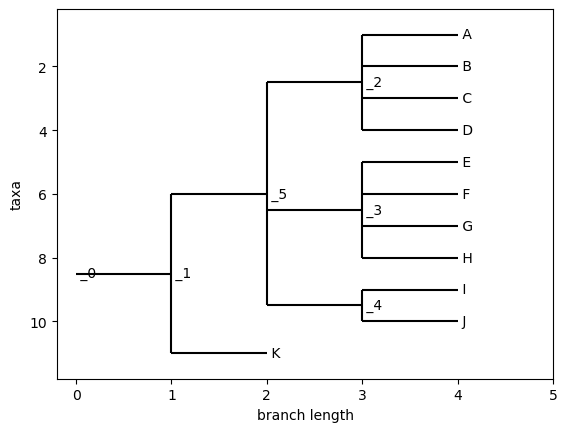

In [141]:
Phylo.draw(tree_pt)

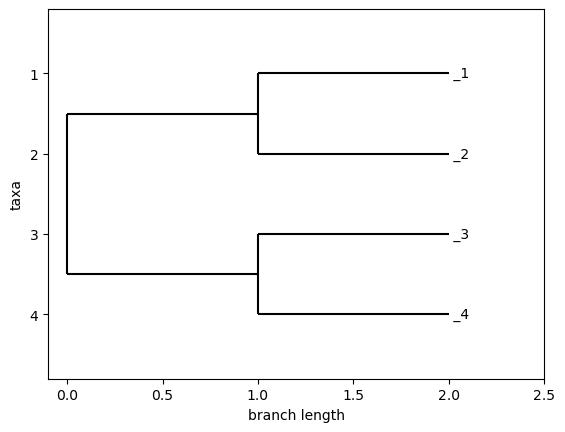

In [142]:
Phylo.draw(resolution1)

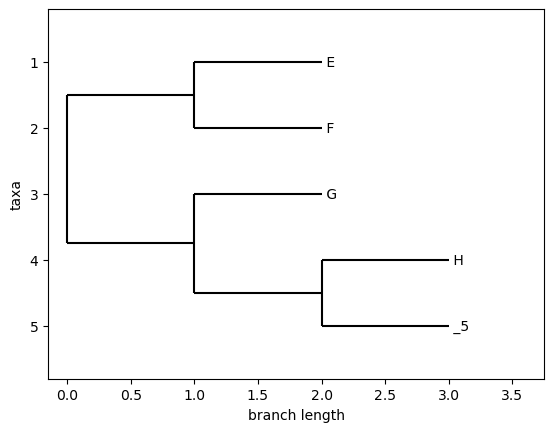

In [143]:
Phylo.draw(resolution2)

In [144]:
from copy import deepcopy

In [ ]:
def resolve_one_polytomy(
    tree_pt, # tree with polytomy
    pt_node_name, # node name of the polytomy to resolve
    resolution_tree, # the resolution tree such that the leafset of this tree is exactly the neighbours of pt_node_name in tree_pt
): 
    """
    Input:
    tree_pt, tree with polytomy
    pt_node_name, node name of the polytomy to resolve
    resolution_tree, the resolution tree such that the leafset of this tree is exactly the neighbours of pt_node_name in tree_pt
    Output: 
    tree_pt with the resolution tree in place of the original polytomy at pt_node_name. 
    Tree WILL have unifurcations, but they are intended and should be fixed AFTER all polytomies are fixed, as they help to represent nodes that are may no longer present.
    Will not chagne resolution_tree, but CHANGES tree_pt IN PLACE
    """
    # assumptions: tree_pt
    # 
    old_resolution_tree = deepcopy(resolution_tree)
    assert len(list(tree_pt.find_clades(target=pt_node_name))) == 1, f"found multiple nodes with name {pt_node_name}"
    pt_node = next(iter(tree_pt.find_clades(target=pt_node_name)))
    parent = get_parent(tree_pt, pt_node)
    assert parent is not None, "parent of polytomy should not be none."
    assert set([parent.name] + [ clade.name for clade in pt_node.clades ]) ==\
        set([ leaf.name for leaf in resolution_tree.find_elements(terminal=True) ] ),\
        f"Resolution leaf set is not the same as the neighbours of the polytomy:\n{set([parent.name] + [ clade.name for clade in pt_node.clades ])}\n{set([ leaf.name for leaf in resolution_tree.find_elements(terminal=True) ] )}"
    # stitch the children the original polytomy on the resolution
    for child in pt_node.clades:
        name = child.name 
        assert len(list(resolution_tree.find_clades(target=name, terminal=True))) == 1, f"Found multiple or no nodes in the resolution with name {name}"
        resolution_child = next(iter(resolution_tree.find_clades(target=name, terminal=True)))
        resolution_child.clades = [child]
        resolution_child.name = pt_node.name
        print(resolution_child, resolution_child.clades)

    # replace the parent -> polytomy node with the tree in tree_pt
    resolution_tree.root_with_outgroup([parent.name])
    resolution_tree.prune(parent.name)
    for i, c in enumerate(parent.clades):
        if c.name == pt_node.name:
            parent.clades[i] = resolution_tree.root
            resolution_tree.root.name = pt_node.name
            break

    resolution_tree = old_resolution_tree
    return tree_pt

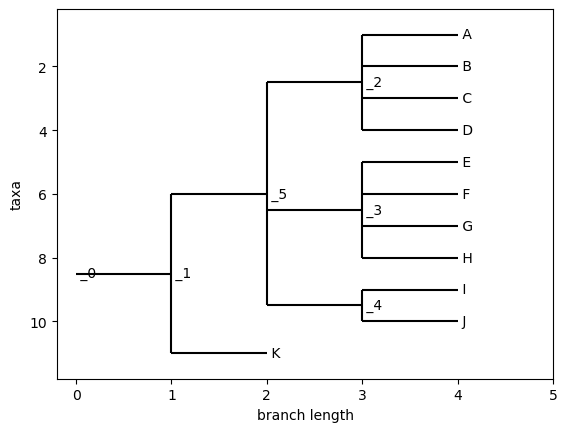

In [146]:
Phylo.draw(tree_pt)

In [147]:
pt_tree = resolve_one_polytomy(
    tree_pt=tree_pt,
    pt_node_name = "_3",
    resolution_tree=resolution2
)

_3 [Clade(name='E')]
_3 [Clade(name='F')]
_3 [Clade(name='G')]
_3 [Clade(name='H')]


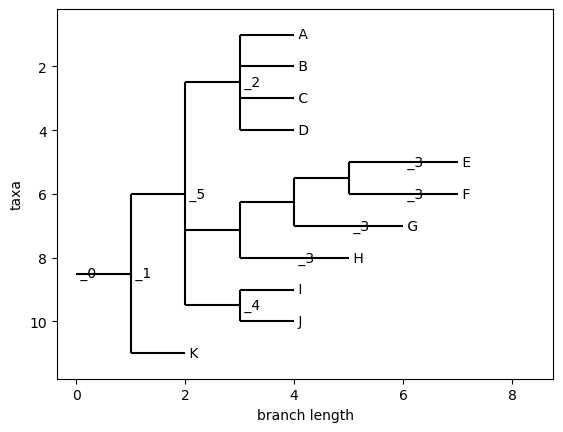

In [148]:
Phylo.draw(pt_tree)

In [149]:
pt_tree = resolve_one_polytomy(
    tree_pt=tree_pt,
    pt_node_name = "_5",
    resolution_tree=resolution1
)

AssertionError: Resolution leaf set is not the same as the neighbours of the polytomy:
{None, '_4', '_1', '_2'}
{'_4', '_3', '_1', '_2'}

In [ ]:
Phylo.draw(pt_tree)